# Filtered DInSAR interferograms

In [1]:
service = dict([('title', 'ETHZ-01-02-01 Filtered DInSAR interferograms'),
                ('abstract', 'ETHZ-01-02-01 Filtered DInSAR interferograms'),
                ('id', 'ewf-ethz-01-02-01')])

In [2]:
eq_id = dict([('id', 'eq_id'),
                   ('value', 'us2000bmcg'),
                   ('title', 'Earthquake Identifier'),
                   ('abstract', 'Earthquake Identifier')])


In [3]:
input_reference = 'dummy'

* First import the Python modules

In [4]:
from osgeo import gdalconst
from PIL import Image
import pandas as pd
from geopandas import GeoDataFrame
from urlparse import urlparse
import py_earthquakes
from shapely.geometry import box
from shapely.wkt import loads
import numpy as np
import os
#from IPython.core.display import display, HTML

import cioppy

from ipywidgets import HTML
from ipyleaflet import *
from datetime import datetime, timedelta
import dateutil.parser

import gdal, osr

%matplotlib inline
import matplotlib.pyplot as plt

Let's first create a map window to help understanding and providing a geographic context to the earthquake and event associated discovered Sentinel-1 data.

In [5]:
eq_search = py_earthquakes.EarthQuakes() 

In [6]:
eq_search.search_id(eq_id['value'])

In [7]:
print eq_search.earthquakes[0].title
print eq_search.earthquakes[0].id
print eq_search.earthquakes[0].date
print eq_search.earthquakes[0].wkt

M 7.3 - 29km S of Halabjah, Iraq
us2000bmcg
2017-11-12T19:18:17.180000Z
POINT(45.9592 34.9109)


In [8]:
def get_aoi(point_wkt, buffer):
    
     return box(*loads(point_wkt).buffer(float(buffer)).bounds)

In [9]:
aoi = get_aoi(eq_search.earthquakes[0].wkt, 0.9)

In [10]:
aoi.wkt

'POLYGON ((46.8592 34.0109, 46.8592 35.8109, 45.0592 35.8109, 45.0592 34.0109, 46.8592 34.0109))'

Get the data about the earthquake:

### Download the coherence products generated

Set the platform access token to download the coherence products:

In [11]:
search_start_date = (dateutil.parser.parse(eq_search.earthquakes[0].date) + timedelta(days=-1)).isoformat()
search_stop_date = (dateutil.parser.parse(eq_search.earthquakes[0].date) + timedelta(days=+1)).isoformat()


Loop through the results produced and download the coherence products:

In [12]:
search_params = dict([('geom', aoi),
                      ('start', search_start_date),
                      ('stop', search_stop_date)])

In [13]:
ciop = cioppy.Cioppy()

end_point = 'https://catalog.terradue.com/dlr-insarql/description'

try:
    search = GeoDataFrame(ciop.search(end_point=end_point, 
                                  params=search_params,
                                  output_fields='enclosure,identifier,self,startdate,enddate,title,wkt,track',
                                  model='EOP')) 
except IndexError:
    print 'At this stage, no InSAR Quicklook products for this earthquake'
    raise IndexError

In [14]:
search['wkt'] = search['wkt'].apply(loads)
search['startdate'] = pd.to_datetime(search['startdate'])
search['enddate'] = pd.to_datetime(search['enddate'])  

In [15]:
def analyse(row, aoi, event_date):
    series = dict()
    
    series['contains'] = row['wkt'].contains(aoi)
    
    series['aoi_intersec'] = (row['wkt'].intersection(aoi).area/aoi.area) * 100
    
    series['band'] = row['identifier'].split('/')[-1].split('.')[0]
    
    series['delta_start'] = round(divmod((pd.to_datetime(event_date) - row['startdate']).total_seconds(), 3600 * 24)[0] +
                              round(divmod((pd.to_datetime(event_date) - row['startdate']).total_seconds(), 3600 * 24)[1])/(3600 * 24))
    
    series['delta_end'] = round(divmod((row['enddate'] - pd.to_datetime(event_date)).total_seconds(), 3600 * 24)[0] +
                              round(divmod((row['enddate'] - pd.to_datetime(event_date)).total_seconds(), 3600 * 24)[1])/(3600 * 24))
    
    series['centroid_distance'] = aoi.centroid.distance(row['wkt'].centroid)
    
    series['centroid_nvector_x'] = (row['wkt'].centroid.x - aoi.centroid.x) / aoi.centroid.distance(row['wkt'].centroid)
    series['centroid_nvector_y'] = (row['wkt'].centroid.y - aoi.centroid.y) / aoi.centroid.distance(row['wkt'].centroid)
    return pd.Series(series)

In [16]:
search = search.merge(search.apply(lambda row: analyse(row, aoi, eq_search.earthquakes[0].date), axis=1), 
              left_index=True,
              right_index=True)

In [17]:
search

,enclosure,enddate,identifier,self,startdate,title,track,wkt,aoi_intersec,band,centroid_distance,centroid_nvector_x,centroid_nvector_y,contains,delta_end,delta_start
0,https://store.terradue.com/dlr-insarql/product...,2017-11-24 03:02:16,S1A_IW_SLC__1SDV_20171112T030148_20171112T0302...,https://catalog.terradue.com/dlr-insarql/searc...,2017-11-12 03:01:49.796626,S-1 Medium-Resolution InSAR Browse Service - I...,79,"POLYGON ((43.4508019999999 34.262031, 46.60112...",73.711297,GEO_DPHASE,1.012817,-0.921425,0.388557,False,11.0,1.0
1,https://store.terradue.com/dlr-insarql/product...,2017-11-24 03:02:16,S1A_IW_SLC__1SDV_20171112T030148_20171112T0302...,https://catalog.terradue.com/dlr-insarql/searc...,2017-11-12 03:01:49.796626,S-1 Medium-Resolution InSAR Browse Service - C...,79,"POLYGON ((43.4508019999999 34.262031, 46.60112...",73.711297,GEO_DCOHER,1.012817,-0.921425,0.388557,False,11.0,1.0
2,https://store.terradue.com/dlr-insarql/product...,2017-11-24 03:02:16,S1A_IW_SLC__1SDV_20171112T030148_20171112T0302...,https://catalog.terradue.com/dlr-insarql/searc...,2017-11-12 03:01:49.796626,S-1 Medium-Resolution InSAR Browse Service - C...,79,"POLYGON ((43.4508019999999 34.262031, 46.60112...",73.711297,GEO_COH_AMPL,1.012817,-0.921425,0.388557,False,11.0,1.0
3,https://store.terradue.com/dlr-insarql/product...,2017-11-24 03:02:16,S1A_IW_SLC__1SDV_20171112T030148_20171112T0302...,https://catalog.terradue.com/dlr-insarql/searc...,2017-11-12 03:01:49.796626,S-1 Medium-Resolution InSAR Browse Service - A...,79,"POLYGON ((43.4508019999999 34.262031, 46.60112...",73.711297,GEO_AMPL_CHANGE,1.012817,-0.921425,0.388557,False,11.0,1.0
4,https://store.terradue.com/dlr-insarql/product...,2017-11-24 03:01:50,S1A_IW_SLC__1SDV_20171112T030123_20171112T0301...,https://catalog.terradue.com/dlr-insarql/searc...,2017-11-12 03:01:24.969617,S-1 Medium-Resolution InSAR Browse Service - I...,79,"POLYGON ((43.753272 35.815354, 46.974824 35.81...",0.000000,GEO_DPHASE,2.034349,-0.292552,0.956250,False,11.0,1.0
5,https://store.terradue.com/dlr-insarql/product...,2017-11-24 03:01:50,S1A_IW_SLC__1SDV_20171112T030123_20171112T0301...,https://catalog.terradue.com/dlr-insarql/searc...,2017-11-12 03:01:24.969617,S-1 Medium-Resolution InSAR Browse Service - C...,79,"POLYGON ((43.753272 35.815354, 46.974824 35.81...",0.000000,GEO_DCOHER,2.034349,-0.292552,0.956250,False,11.0,1.0
6,https://store.terradue.com/dlr-insarql/product...,2017-11-24 03:01:50,S1A_IW_SLC__1SDV_20171112T030123_20171112T0301...,https://catalog.terradue.com/dlr-insarql/searc...,2017-11-12 03:01:24.969617,S-1 Medium-Resolution InSAR Browse Service - C...,79,"POLYGON ((43.753272 35.815354, 46.974824 35.81...",0.000000,GEO_COH_AMPL,2.034349,-0.292552,0.956250,False,11.0,1.0
7,https://store.terradue.com/dlr-insarql/product...,2017-11-24 03:01:50,S1A_IW_SLC__1SDV_20171112T030123_20171112T0301...,https://catalog.terradue.com/dlr-insarql/searc...,2017-11-12 03:01:24.969617,S-1 Medium-Resolution InSAR Browse Service - A...,79,"POLYGON ((43.753272 35.815354, 46.974824 35.81...",0.000000,GEO_AMPL_CHANGE,2.034349,-0.292552,0.956250,False,11.0,1.0
8,https://store.terradue.com/dlr-insarql/product...,2017-11-23 15:00:56,S1A_IW_SLC__1SDV_20171111T150029_20171111T1500...,https://catalog.terradue.com/dlr-insarql/searc...,2017-11-11 15:00:29.814081,S-1 Medium-Resolution InSAR Browse Service - I...,72,"POLYGON ((43.012913 34.932108, 46.208917 34.93...",31.184015,GEO_DPHASE,1.702050,-0.792154,0.610322,False,11.0,1.0
9,https://store.terradue.com/dlr-insarql/product...,2017-11-23 15:00:56,S1A_IW_SLC__1SDV_20171111T150029_20171111T1500...,https://catalog.terradue.com/dlr-insarql/searc...,2017-11-11 15:00:29.814081,S-1 Medium-Resolution InSAR Browse Service - C...,72,"POLYGON ((43.012913 34.932108, 46.208917 34.93...",31.184015,GEO_DCOHER,1.702050,-0.792154,0.610322,False,11.0,1.0


In [18]:
search.to_pickle('%s_search.pkl' % eq_search.earthquakes[0].id)

# properties file
with open('%s_search.properties' % eq_search.earthquakes[0].id, 'wb') as file:
    file.write('title=Pickle file for search (%s)\n' % eq_search.earthquakes[0].id)
    file.write('date=%s\n' % eq_search.earthquakes[0].date)
    file.write('geometry=%s' % eq_search.earthquakes[0].wkt)


In [19]:
selected = pd.DataFrame()

for band in list(search['band'].unique()):
    try:
        row = search[(search['band'] == band) & (search['contains'] == True) & (search['centroid_nvector_x'] < 0)].sort_values(['centroid_distance', 'delta_start', 'delta_end'], ascending=[False, False, False]).iloc[0]
    except IndexError:
        row = search[(search['band'] == band) & (search['centroid_nvector_x'] < 0) & (search['centroid_nvector_y'] < 0)].sort_values(['aoi_intersec', 'centroid_distance', 'delta_start', 'delta_end'], ascending=[False, False, False, False]).iloc[0]

        
    selected = selected.append(row, ignore_index=True)
     

In [20]:
selected

,aoi_intersec,band,centroid_distance,centroid_nvector_x,centroid_nvector_y,contains,delta_end,delta_start,enclosure,enddate,identifier,self,startdate,title,track,wkt
0,65.235966,GEO_DPHASE,1.119207,-0.913879,-0.405988,0.0,11.0,1.0,https://store.terradue.com/dlr-insarql/product...,2017-11-23 15:00:31,S1A_IW_SLC__1SDV_20171111T150004_20171111T1500...,https://catalog.terradue.com/dlr-insarql/searc...,2017-11-11 15:00:04.989128,S-1 Medium-Resolution InSAR Browse Service - I...,72,"POLYGON ((43.370041 33.437903, 46.502721 33.43..."
1,65.235966,GEO_DCOHER,1.119207,-0.913879,-0.405988,0.0,11.0,1.0,https://store.terradue.com/dlr-insarql/product...,2017-11-23 15:00:31,S1A_IW_SLC__1SDV_20171111T150004_20171111T1500...,https://catalog.terradue.com/dlr-insarql/searc...,2017-11-11 15:00:04.989128,S-1 Medium-Resolution InSAR Browse Service - C...,72,"POLYGON ((43.370041 33.437903, 46.502721 33.43..."
2,65.235966,GEO_COH_AMPL,1.119207,-0.913879,-0.405988,0.0,11.0,1.0,https://store.terradue.com/dlr-insarql/product...,2017-11-23 15:00:31,S1A_IW_SLC__1SDV_20171111T150004_20171111T1500...,https://catalog.terradue.com/dlr-insarql/searc...,2017-11-11 15:00:04.989128,S-1 Medium-Resolution InSAR Browse Service - C...,72,"POLYGON ((43.370041 33.437903, 46.502721 33.43..."
3,65.235966,GEO_AMPL_CHANGE,1.119207,-0.913879,-0.405988,0.0,11.0,1.0,https://store.terradue.com/dlr-insarql/product...,2017-11-23 15:00:31,S1A_IW_SLC__1SDV_20171111T150004_20171111T1500...,https://catalog.terradue.com/dlr-insarql/searc...,2017-11-11 15:00:04.989128,S-1 Medium-Resolution InSAR Browse Service - A...,72,"POLYGON ((43.370041 33.437903, 46.502721 33.43..."


In [21]:
global m

from ipyleaflet import Map, Polygon

map_x = loads(eq_search.earthquakes[0].wkt).x
map_y = loads(eq_search.earthquakes[0].wkt).y

m = Map(center=(map_y, map_x), zoom=7)

aoi_map = Polygon(
    locations=np.asarray([t[::-1] for t in list(aoi.exterior.coords)]).tolist(),
    color="green",
    fill_color="green"
)

prod_map = Polygon(
    locations=np.asarray([t[::-1] for t in list(selected.iloc[0]['wkt'].exterior.coords)]).tolist(),
    color="red",
    fill_color="red"
)

m.add_layer(prod_map);
m.add_layer(aoi_map);
m

TWFwKGJhc2VtYXA9eyd1cmwnOiAnaHR0cHM6Ly97c30udGlsZS5vcGVuc3RyZWV0bWFwLm9yZy97en0ve3h9L3t5fS5wbmcnLCAnbWF4X3pvb20nOiAxOSwgJ2F0dHJpYnV0aW9uJzogJ01hcCDigKY=


In [22]:
def get_image_as_array(row, bbox, earthquake):
    
    output = '/vsimem/clip.tif'

    
    parsed_url = urlparse(row['enclosure'])
    
    url = '%s://%s/api%s' % (list(parsed_url)[0], list(parsed_url)[1], list(parsed_url)[2])
    print url
    vsi_url = '/vsicurl/%s' % url


    ds = gdal.Open('/vsicurl/%s' % url)
    # get the GeoTransform from the product on store
    geo_transform = ds.GetGeoTransform()
    
    gt = list(geo_transform)
    # correct it
    gt[2] = gt[4] = 0
    geo_transform_new = tuple(gt)

    # get the full remote product in memory
    gdal.Translate(output, ds)

    ds.RasterCount
    ds = None

    # open the full product in memory
    dsmem = gdal.Open(output, gdalconst.GA_Update)
    # correct the geotransform
    dsmem.SetGeoTransform(geo_transform_new)


    clip = '/vsimem/mem.tif'
    # extract the AOI
    
    ulx, uly, lrx, lry = bbox[0], bbox[3], bbox[2], bbox[1] 
    gdal.Translate(clip, dsmem, projWin = [ulx, uly, lrx, lry], projWinSRS = 'EPSG:4326')

    dsmem = None

    # open the subset (in memory)
    ds = gdal.Open(clip)

    band = ds.GetRasterBand(1)

    w = band.XSize
    h = band.YSize
    
    drv = gdal.GetDriverByName('GTiff')
    ds_out = drv.Create('%s_%s_export.tif' % (earthquake.id, row['band']), w, h, ds.RasterCount, gdal.GDT_Byte)
    ds_out.SetGeoTransform(ds.GetGeoTransform())
    ds_out.SetProjection(ds.GetProjection())
    
    data = []
    for index in range(ds.RasterCount):
        
        band = ds.GetRasterBand(index+1)
        
        if index != 3: # no transparency
                
            data.append(band.ReadAsArray(0, 0, w, h).astype(np.uint8))

        ds_out.GetRasterBand(index+1).WriteArray(band.ReadAsArray(0, 0, w, h).astype(np.uint8), 0, 0)
    
    
    stack = np.dstack(data).astype(np.uint8)

    ds_out.FlushCache()
    
    ds_out = None
    ds = None
    
    # properties file
    with open('%s_%s_export.properties' % (earthquake.id, row['band']), 'wb') as file:
        file.write('title=%s - %s\n' % (earthquake.id, row['band']))
        file.write('date=%s\n' % earthquake.date)
        file.write('geometry=%s' % earthquake.wkt)
    
    
    return stack

In [23]:
def get_data(row, aoi, earthquake):
    extended_info = dict()

    extended_info['image_data'] = get_image_as_array(row, aoi.bounds, earthquake)

    series = pd.Series(extended_info)
        
    return series

In [24]:
selected = selected.merge(selected.apply(lambda row: get_data(row, aoi, eq_search.earthquakes[0]), axis=1), left_index=True, right_index=True)

https://store.terradue.com/api/dlr-insarql/production/2017/11/24/S1A_IW_SLC__1SDV_20171111T150004_20171111T150032_019219_0208AF_EE89_S1A_IW_SLC__1SDV_20171123T150004_20171123T150031_019394_020E36_23EE/GEO_DPHASE.tiff
https://store.terradue.com/api/dlr-insarql/production/2017/11/24/S1A_IW_SLC__1SDV_20171111T150004_20171111T150032_019219_0208AF_EE89_S1A_IW_SLC__1SDV_20171123T150004_20171123T150031_019394_020E36_23EE/GEO_DCOHER.tiff
https://store.terradue.com/api/dlr-insarql/production/2017/11/24/S1A_IW_SLC__1SDV_20171111T150004_20171111T150032_019219_0208AF_EE89_S1A_IW_SLC__1SDV_20171123T150004_20171123T150031_019394_020E36_23EE/GEO_COH_AMPL.tiff
https://store.terradue.com/api/dlr-insarql/production/2017/11/24/S1A_IW_SLC__1SDV_20171111T150004_20171111T150032_019219_0208AF_EE89_S1A_IW_SLC__1SDV_20171123T150004_20171123T150031_019394_020E36_23EE/GEO_AMPL_CHANGE.tiff


In [25]:
selected

,aoi_intersec,band,centroid_distance,centroid_nvector_x,centroid_nvector_y,contains,delta_end,delta_start,enclosure,enddate,identifier,self,startdate,title,track,wkt,image_data
0,65.235966,GEO_DPHASE,1.119207,-0.913879,-0.405988,0.0,11.0,1.0,https://store.terradue.com/dlr-insarql/product...,2017-11-23 15:00:31,S1A_IW_SLC__1SDV_20171111T150004_20171111T1500...,https://catalog.terradue.com/dlr-insarql/searc...,2017-11-11 15:00:04.989128,S-1 Medium-Resolution InSAR Browse Service - I...,72,"POLYGON ((43.370041 33.437903, 46.502721 33.43...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,65.235966,GEO_DCOHER,1.119207,-0.913879,-0.405988,0.0,11.0,1.0,https://store.terradue.com/dlr-insarql/product...,2017-11-23 15:00:31,S1A_IW_SLC__1SDV_20171111T150004_20171111T1500...,https://catalog.terradue.com/dlr-insarql/searc...,2017-11-11 15:00:04.989128,S-1 Medium-Resolution InSAR Browse Service - C...,72,"POLYGON ((43.370041 33.437903, 46.502721 33.43...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,65.235966,GEO_COH_AMPL,1.119207,-0.913879,-0.405988,0.0,11.0,1.0,https://store.terradue.com/dlr-insarql/product...,2017-11-23 15:00:31,S1A_IW_SLC__1SDV_20171111T150004_20171111T1500...,https://catalog.terradue.com/dlr-insarql/searc...,2017-11-11 15:00:04.989128,S-1 Medium-Resolution InSAR Browse Service - C...,72,"POLYGON ((43.370041 33.437903, 46.502721 33.43...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,65.235966,GEO_AMPL_CHANGE,1.119207,-0.913879,-0.405988,0.0,11.0,1.0,https://store.terradue.com/dlr-insarql/product...,2017-11-23 15:00:31,S1A_IW_SLC__1SDV_20171111T150004_20171111T1500...,https://catalog.terradue.com/dlr-insarql/searc...,2017-11-11 15:00:04.989128,S-1 Medium-Resolution InSAR Browse Service - A...,72,"POLYGON ((43.370041 33.437903, 46.502721 33.43...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [26]:
selected.to_pickle('%s_selected.pkl' % eq_search.earthquakes[0].id)

# properties file
with open('%s_selected.properties' % eq_search.earthquakes[0].id, 'wb') as file:
    file.write('title=Pickle file for selected (%s)\n' % eq_search.earthquakes[0].id)
    file.write('date=%s\n' % eq_search.earthquakes[0].date)
    file.write('geometry=%s' % eq_search.earthquakes[0].wkt)

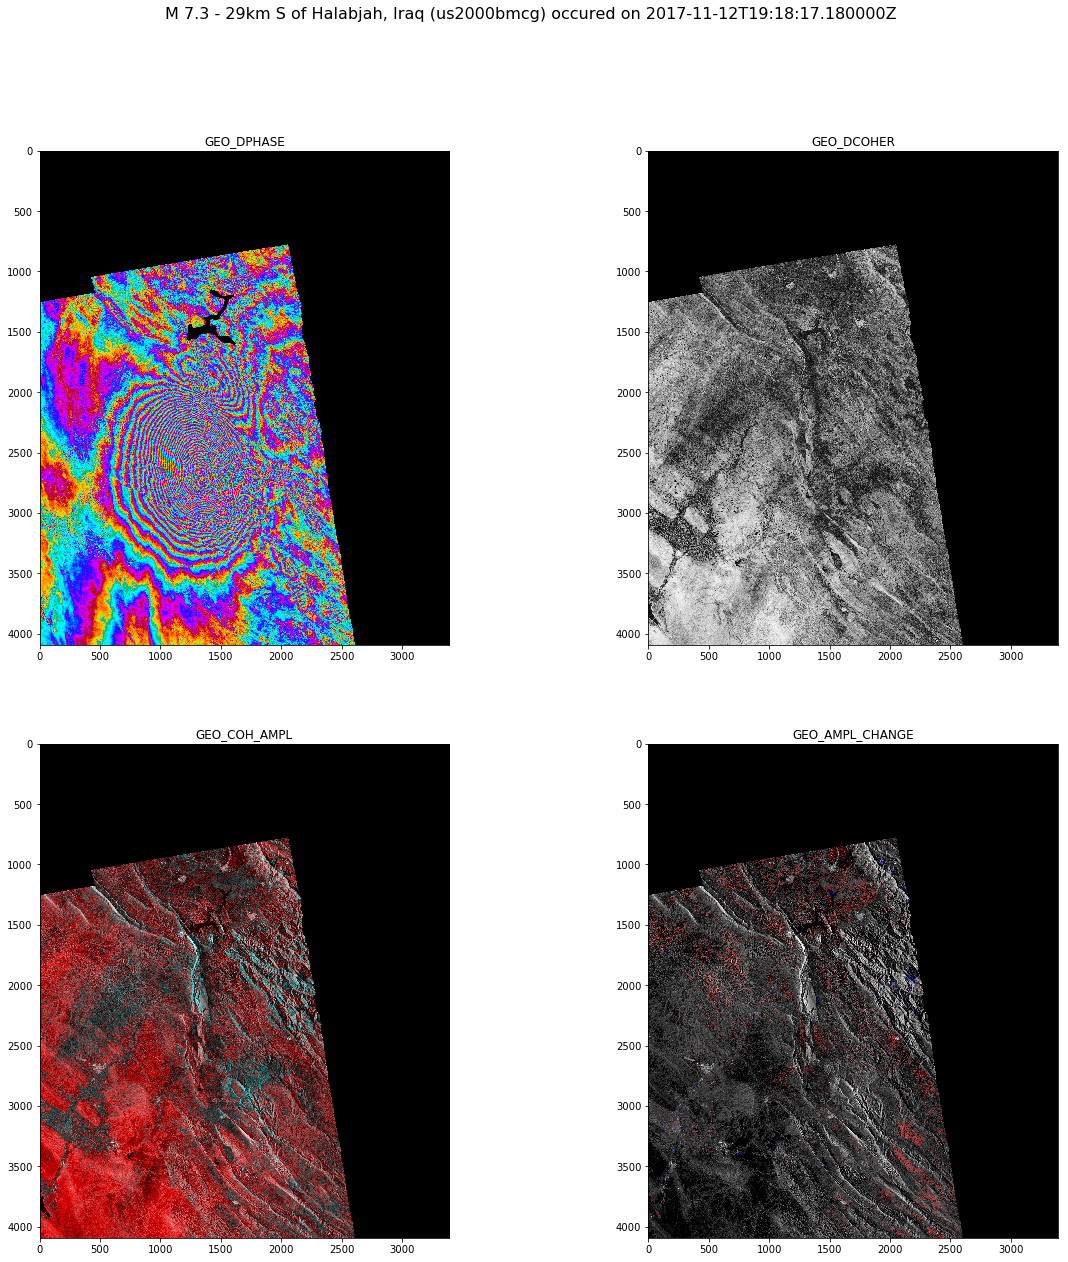

In [27]:
fig = plt.figure(figsize=(20,20))

fig.suptitle('%s (%s) occured on %s' % (eq_search.earthquakes[0].title, 
             eq_search.earthquakes[0].id,
             eq_search.earthquakes[0].date), fontsize=16)

for index, band in enumerate(list(selected['band'].values)):

    data = selected[selected['band'] == band]['image_data'].values[0]
    
    sub_fig = fig.add_subplot(2, 2, index+1)
    img = Image.fromarray(data)
    imgplot = plt.imshow(img)

    sub_fig.set_title(band)

fig.savefig('%s.png' % eq_search.earthquakes[0].id)

# properties file
with open('%s.properties' % eq_search.earthquakes[0].id, 'wb') as file:
    file.write('title=%s (%s)\n' % (eq_search.earthquakes[0].title, 
                                  eq_search.earthquakes[0].id))
    file.write('date=%s\n' % eq_search.earthquakes[0].date)
    file.write('geometry=%s' % eq_search.earthquakes[0].wkt)

In [28]:
#notebook properties
with open('result.properties', 'wb') as file:
    file.write('title=Reproducibility notebook for event %s\n' % eq_search.earthquakes[0].id)
    file.write('date=%s\n' % eq_search.earthquakes[0].date)
    file.write('geometry=%s' % eq_search.earthquakes[0].wkt)

### License

This work is licenced under a [Attribution-ShareAlike 4.0 International License (CC BY-SA 4.0)](http://creativecommons.org/licenses/by-sa/4.0/) 

YOU ARE FREE TO:

* Share - copy and redistribute the material in any medium or format.
* Adapt - remix, transform, and built upon the material for any purpose, even commercially.

UNDER THE FOLLOWING TERMS:

* Attribution - You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.
* ShareAlike - If you remix, transform, or build upon the material, you must distribute your contributions under the same license as the original.